In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

This notebook uses the following scripts that can be found in the Material repository in the directory VRPTW:
    - data.py
    - compact.py
    - heuristic.py
    - extended_cg.py
The scripts use the module scipyopt instead of pyomo. 

In [2]:
import os, sys
sys.path.append("../data/")
sys.path.append("../scipopt/")

# VRPTW

## Construction heuristics

In [3]:
from data import *
from heuristic import heuristic

Construct routes by adding the cheapest (nearest) customer that does not violated the capacity and the time window constraint. If no customer can be added to the current route start a new route. Repeat until no customer is unvisited. 

54 [[0, 8, 7, 6, 0], [0, 5, 4, 3, 0], [0, 2, 0], [0, 1, 0]]


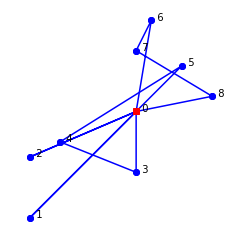

In [4]:
cost, routes = heuristic(data)
print(cost, routes)
data.plot_routes(routes)

## Compact Model

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll=function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

Solving the compact model... 

presolving:
(round 1, fast)       120 del vars, 114 del conss, 0 add conss, 66 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 15 impls, 17 clqs
(round 2, fast)       126 del vars, 162 del conss, 0 add conss, 66 chg bounds, 6 chg sides, 0 chg coeffs, 0 upgd conss, 15 impls, 26 clqs
(round 3, fast)       129 del vars, 162 del conss, 0 add conss, 66 chg bounds, 21 chg sides, 15 chg coeffs, 0 upgd conss, 15 impls, 26 clqs
(round 4, exhaustive) 129 del vars, 162 del conss, 0 add conss, 66 chg bounds, 21 chg sides, 15 chg coeffs, 68 upgd conss, 15 impls, 26 clqs
(round 5, medium)     132 del vars, 165 del conss, 0 add conss, 66 chg bounds, 21 chg sides, 15 chg coeffs, 68 upgd conss, 57 impls, 41 clqs
(round 6, medium)     135 del vars, 168 del conss, 0 add conss, 66 chg bounds, 21 chg sides, 15 chg coeffs, 68 upgd conss, 57 impls, 44 clqs
(round 7, medium)     138 del vars, 171 del conss, 0 add conss, 66 chg bounds, 21 chg sides, 15 chg coeffs, 68 upgd co

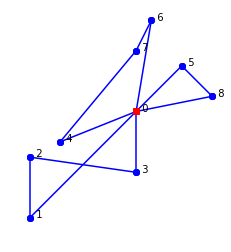

In [7]:
from compact import SolveCompactModel
cost, arcs = SolveCompactModel(data)
print(cost, arcs)
data.plot_routes_arcs(arcs)

Hence, the optimal solution has cost 42. The lower bound provided by the linear relaxation at the root node is 35 and it never increases.

## Extended Formulation

### Column Generation

In [8]:
from extended_cg import enrich_data, solve_extended
enrich_data(data)
solve_extended(data, data.routes, data.costRoutes, data.routes_arcs, SRC=False, BB=False)

----------------------ITERATION 1----------------------

Solving the reduced master problem... with 20 columns 20
reduced to: 20
wrote problem to file b'master_1.lp'
Optimal solution for master problem is 41.66666666666667
Theta vars:  [0.333 0.667 0.    0.    0.667 0.333 0.    0.333 0.    0.333 0.333 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
Dual values:  [-0.    12.     5.333  3.     4.667  6.333  5.667  4.667 -0.   ]
Solving the pricing problem... 
wrote problem to file b'subproblem_1.lp'
Optimal solution for pricing problem is -5.666666666666664
Selected arcs:  [(0, 7), (5, 9), (6, 5), (7, 6)]  Nodes:  [0, 5, 6, 7, 9]  Cost:  11
Add new column to RMP:  [1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
Costs: [15. 12. 22. 18. 15. 22. 18. 10. 15. 11. 13. 12. 14. 10.  6.  6.  8. 10.
  8.  6. 11.]
----------------------ITERATION 2----------------------

Solving the reduced master problem... with 21 columns 21
reduced to: 21
wrote problem to file b'master_2.lp'
Optimal solution for master prob

(40.0, [])

Hence the lower bound provided by column generation is 40, which is much better than the LP relaxation (35).
Let's solve with SRC cuts.

### Column Generation with Subset Row Cuts

In [9]:
enrich_data(data)
cost, routes = solve_extended(data, data.routes, data.costRoutes, data.routes_arcs, SRC=True, BB=False)

----------------------ITERATION 1----------------------

Solving the reduced master problem... with 28 columns 28
reduced to: 28
wrote problem to file b'master_1.lp'
Optimal solution for master problem is 41.66666666666667
Theta vars:  [0.333 0.667 0.    0.    0.667 0.333 0.    0.333 0.    0.333 0.333 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Dual values:  [-0.    12.     5.333  3.     4.667  6.333  5.667  4.667 -0.   ]
Solving the pricing problem... 
wrote problem to file b'subproblem_1.lp'
Optimal solution for pricing problem is -5.666666666666664
Selected arcs:  [(0, 7), (5, 9), (6, 5), (7, 6)]  Nodes:  [0, 5, 6, 7, 9]  Cost:  11
Add new column to RMP:  [1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
Costs: [15. 12. 22. 18. 15. 22. 18. 10. 15. 11. 13. 12. 14. 10.  6.  6.  8. 10.
  8.  6. 14. 10.  6.  6.  8. 10.  8.  6. 11.]
----------------------ITERATION 2----------------------

Solving the reduced master problem... with 29 columns 29
reduce

Hence with Subset row cuts we end up with an integer soution which is also optimal for the original problem.

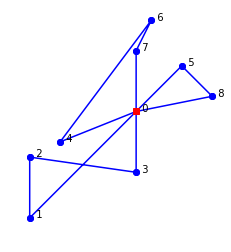

In [10]:
data.plot_routes(routes)

### Branch and Price 

In [11]:
import numpy as np 
np.random.seed(3)
enrich_data(data)
cost, routes = solve_extended(data, data.routes, data.costRoutes, data.routes_arcs, SRC=False, BB=True)

----------------------ITERATION 1----------------------

Solving the reduced master problem... with 36 columns 36
reduced to: 36
wrote problem to file b'master_1.lp'
Optimal solution for master problem is 41.66666666666667
Theta vars:  [0.333 0.667 0.    0.    0.667 0.333 0.    0.333 0.    0.333 0.333 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Dual values:  [-0.    12.     5.333  3.     4.667  6.333  5.667  4.667 -0.   ]
Solving the pricing problem... 
wrote problem to file b'subproblem_1.lp'
Optimal solution for pricing problem is -5.666666666666664
Selected arcs:  [(0, 7), (5, 9), (6, 5), (7, 6)]  Nodes:  [0, 5, 6, 7, 9]  Cost:  11
Add new column to RMP:  [1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
Costs: [15. 12. 22. 18. 15. 22. 18. 10. 15. 11. 13. 12. 14. 10.  6.  6.  8. 10.
  8.  6. 14. 10.  6.  6.  8. 10.  8.  6. 14. 10.  6.  6.  8. 10.  8.  6.
 11.]
----------------------ITERATION 2------

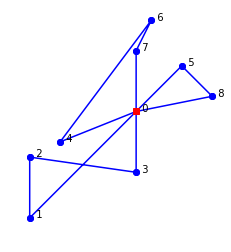

In [12]:
data.plot_routes(routes)

The search tree:

![tree](tree.png)
